# Creates quadratic equations for oxidation and reduction of the elements

In [1]:
import pickle 
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.spatial import ConvexHull

import warnings
warnings.filterwarnings("error")


Need to pickle in the data we've gathered from mp


this gives some deprecation warning but nothing seems to be wrong, if you rerun it works fine.

In [3]:
unary_data = pickle.load(open("unary_oxide_data_self_calc.p", "rb"))


Exception ignored in: <_io.FileIO name='unary_oxide_data_self_calc.p' mode='rb' closefd=True>
Traceback (most recent call last):
  File "/var/folders/0j/hf77bqls62l2jv_3n8b5dgx80000gn/T/ipykernel_31694/2046442955.py", line 1, in <cell line: 1>


In [4]:
def get_lowest_ene_id(element, oxidation_state):
    """
    Return the materials project id that is the lowest formation energy
    at that oxidation_state, related to relative mol. fraction of O
    """
    ref_formation_energy = 0
    ref_id = None
    for idx, struct in enumerate(unary_data[element]['structures']):
        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        if ox_state==oxidation_state:
            formation_energy = unary_data[element]['formation_energies'][idx]
            if formation_energy<ref_formation_energy:
                ref_id = unary_data[element]['mp_ids'][idx]
                ref_formation_energy = formation_energy
    # if we return None
    # there isn't a value for this in materials project, need to invent
    # one later on, and label this as None, to be handled in get_ref_data
    return ref_id

def get_ref_data(element, reference_oxide_id, desired_ox):
    found = False
    
    if reference_oxide_id is None:
        print("Making synthetic formation energy, since MP doesn't have data for {} in ox state: {}".format(element, desired_ox))
        ene_dict, val = get_ox2lowest_no_reference_(element, desired_ox)
        return val, _

    for idx, id_ in enumerate(unary_data[element]['mp_ids']):
        if id_==reference_oxide_id:
            found = True
            ref_struct = unary_data[element]['structures'][idx]
            ref_form_ene = unary_data[element]['formation_energies'][idx]
            return ref_form_ene, ref_struct
    
    print("You probably mis-named ones of the reference oxides.")
    return 

def get_ox2lowest_no_reference_(reference_element_, ref_oxidation_state):
    """
    Returns a dictionary for a given element with keys for ox state and 
    values for the lowest formation energy at ox state.
    Args:
    reference_element_: The element to iterate over, passed as a string
    """
    ox2lowest = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):

        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        formation_energy = unary_data[reference_element_]['formation_energies'][idx]
        
        if ox_state not in ox2lowest.keys():
            ox2lowest[ox_state] = formation_energy
        elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state]:
            ox2lowest[ox_state] = formation_energy
    if ref_oxidation_state not in ox2lowest.keys():
        synthetic_ref_form = add_ox(ox2lowest, ref_oxidation_state)
        ox2lowest[ref_oxidation_state] = synthetic_ref_form
        
    return ox2lowest, ox2lowest[ref_oxidation_state]

def get_hull_energy(min_mu_o, max_mu_o, entries):
    list_mu_Os = np.linspace(min_mu_o, max_mu_o, 10)
    data = []
    hull = []
    for mu_Os in list_mu_Os:
        open_elements_specific = {Element("O"):mu_Os}
        gcpd = GrandPotentialPhaseDiagram(entries, open_elements_specific)
        l = [gcpd.get_form_energy_per_atom(e) for e in gcpd.all_entries]
        h = [gcpd.get_e_above_hull(e) for e in gcpd.all_entries]
        data.append(l)
        hull.append(h)
    hull = np.array(hull)
    data = np.array(data)
    return hull, data, gcpd, list_mu_Os

def structure_inspection(structure):
    """
    Need to know the coordination and other structural data for a given oxide
    """
    num_o_sites = 0 
    m_coordinations = []
    o_o_coordinations = []
    o_m_coordinations = []
    for site in structure.sites:
        if str(site.specie)=='O':
            num_o_sites += 1
            nn_info = structure.get_neighbors(site, 2.5)
            o_coord = 0
            o_m_coord = 0
            for nn in nn_info:
                if str(nn.specie)=="O" and nn.nn_distance<1.5:
                    o_coord+=1
                elif str(nn.specie)!="O":
                    o_m_coord+=1
                #assert str(nn.specie)=='O'
            o_o_coordinations.append(o_coord)
            o_m_coordinations.append(o_m_coord)
        else:
            # check nearest neighbours for coordination
            nn_info = structure.get_neighbors(site, 2.5)
            m_coord = 0
            for nn in nn_info:
                if str(nn.specie)=="O":
                    m_coord+=1
                #assert str(nn.specie)=='O'
            m_coordinations.append(m_coord)
    o_percent = num_o_sites/len(structure.sites)
    ox_state = round((o_percent*2/(1-o_percent)), 3)
    return m_coordinations, ox_state, o_o_coordinations, o_m_coordinations, round(o_percent, 3)

def add_ox(energy_dict, desired_ox_state):
    """
    Makes a synthetic entry in the dictionary for a given oxidation state if it doesn't exist
    """
    ox_states = list(energy_dict.keys())
    energies = list(energy_dict.values())
    ox_states_ = ox_states.copy()
    assert desired_ox_state not in ox_states
    
    # we need two points to project between or from to the desired oxidation state
    # if the desired points has examples either side of it, we handle that here
    min_energy = min(energies)
    ox_at_min = ox_states[np.argmin(energies)]
    if desired_ox_state<ox_at_min:
        return min_energy*((ox_at_min-desired_ox_state)/ox_at_min)
    else:
        return min_energy*((desired_ox_state-ox_at_min)/(8-ox_at_min))

def get_all_ref_data(ox_state):
    ele2mp_ = defaultdict()
    for ele in unary_data.keys():
        if len(unary_data[ele]['names'])==0:
            continue
            
        ele2mp_[ele] = get_lowest_ene_id(ele, ox_state, )

    ref_data = defaultdict()
    for ele in ele2mp_.keys():
        ref_data[ele] = get_ref_data(ele, ele2mp_[ele], ox_state)
        
    return ref_data, ele2mp_
    
def get_quadratic(lower_hull_data, max_x=4):
    """
    Iterate over the hull dictionary to get x and y to fit 2nd order polynomial through those points
    """
    xs = []
    ys = []
    for ox in lower_hull_data:
        xs.append(ox)
        ys.append(lower_hull_data[ox])
    try:
        coeffs_ = np.polyfit(xs, ys, 2)
    except:
        return None
    x = np.linspace(0, max_x, 100)
    y = coeffs_[0]*x**2 + coeffs_[1]*x + coeffs_[2]
    plt.plot(x, y)
    plt.show()
    
    return coeffs_



def check_if_upper(upper_hull_points, hull_simplex):
    """
    Helper function so that for loop in get_lower_hull_points function can be skipped when
    we see a point that is on the upper half of the hull.
    """
    for index in upper_hull_points:
        if index in hull_simplex:
            return True
    return False
    
def get_lower_hull_points(hull_, pairs_, plotting=True):
    """
    Function to remove points on the upper half of the hull, these are unstable and ignored,  
    to handle the fact that scipy gets the entire hull not just the low energy points we want.
    Args: 
    hull_: Returned value from scipy's ConvexHull, where the x-axis is oxidation state and the
    y-axis is formation energy.
    pairs_: The values themselves, pairs_[i, 0] gives the ith oxidation state
    pairs_[i, 1] the ith formation energy.
    plotting: Whether to plot the points to be fitted through
    """
    points_on_upper_hull = set()
    for vertex_index, vertex in enumerate(hull_.vertices):
        # check if on upper or lower half of hull
        for simplex in hull_.simplices:
            low_ox = min(pairs_[simplex, 0])
            low_ox_ene = pairs_[simplex, 1][np.argmin(pairs_[simplex, 0])]
            high_ox = max(pairs_[simplex, 0])
            high_ox_ene = pairs_[simplex, 1][np.argmax(pairs_[simplex, 0])]
            difference = high_ox - low_ox
            vertex_ox = pairs_[vertex, 0]
            vertex_diff = vertex_ox-low_ox
            if difference==0:
                continue
            difference_ratio = vertex_diff/difference
            value_on_hull = high_ox_ene*(1-difference_ratio)+low_ox_ene*(difference_ratio)
            if low_ox<pairs_[vertex,0]<high_ox and value_on_hull<pairs_[vertex,1]:
                # if this is true it means the oxidation state is between two other oxidation states on the hull,
                # and lies above the weighted average on the line connecting those oxidation states
                points_on_upper_hull.add(hull_.vertices[vertex_index])
        
    hullox2ene = defaultdict()
    for simplex in hull_.simplices:
        if check_if_upper(points_on_upper_hull, simplex):
            continue
        hullox2ene[pairs_[simplex, 0][0]] = pairs_[simplex, 1][0]
        hullox2ene[pairs_[simplex, 0][1]] = pairs_[simplex, 1][1] 
        if plotting:
            
            plt.plot(pairs_[simplex, 0], pairs_[simplex, 1], 'k--')
            plt.plot(pairs_[simplex, 0][0], pairs_[simplex, 1][0], 'ro')
            plt.plot(pairs_[simplex, 0][1], pairs_[simplex, 1][1], 'ro')

    return hullox2ene

def get_lower_hull_symmetric(low_ox_state_data, ref_oxidation_state, ref_formation_ene, reference_element_, oxidising=True):
    """
    Returns the lower hull through the desired points along the phase diagram, the difference here 
    is that if there is a structure lower in energy than the reference, we make a symmetric function
    about that minimum, makes it easier to fit things without hard coding a result by eye.
    
    low_ox_state_data: Dictionary returned from the result of get_ox2lowest
    ref_formation_ene: Formation energy in eV/atom of refernece state.
    ref_oxidation_state: The reference oxidation state from which we oxidise/reduce
    oxidising: Set to True if we want the hull oxidised, False if we want it reduced
    """
    pairs = [[0,0]]
    
    going_down = False
    min_energy = 100
    min_ox = 100
    if oxidising:
        for ox in low_ox_state_data:
            if low_ox_state_data[ox][0]<ref_formation_ene:
                # at least one more oxidised entry is lower in energy, will be symmetric about the minimum
                going_down = True
                if low_ox_state_data[ox][0]<min_energy:
                    min_energy = low_ox_state_data[ox][0]
                    min_ox = ox
        if going_down:
            pairs.append((min_ox-ref_oxidation_state, min_energy-ref_formation_ene))
            pairs.append(((min_ox-ref_oxidation_state)*2, 0))
    else:
        for ox in low_ox_state_data:
            if low_ox_state_data[ox][0]<ref_formation_ene:
                # at least one more oxidised entry is lower in energy, will be symmetric about the minimum
                going_down = True
                if low_ox_state_data[ox][0]<min_energy:
                    min_energy = low_ox_state_data[ox][0]
                    min_ox = ox
        if going_down:
            pairs.append((ref_oxidation_state-min_ox, min_energy-ref_formation_ene))
            pairs.append(((ref_oxidation_state-min_ox)*2, 0))

    if oxidising and not going_down:
        for ox in low_ox_state_data:
            pairs.append((ox-ref_oxidation_state,low_ox_state_data[ox][0]-ref_formation_ene ))
    elif not going_down:
        for ox in low_ox_state_data:
            pairs.append((ref_oxidation_state-ox,low_ox_state_data[ox][0]-ref_formation_ene ))        
            
    if len(pairs)==2:
        # need to add oxygen end member data
        print("WARNING! Adding an end member so can perform fit, try gather more data for this element.")
        pairs.append((ref_oxidation_state, -ref_formation_ene))
    
    pairs = np.array(pairs)

    try:
        hull = ConvexHull(pairs)
    except Exception as e:
        print("{}  odd.".format(reference_element_))
        if oxidising:
            plt.title("{} oxidising, not enough data".format(reference_element_))
        else:
            plt.title("{} reducing, not enough data".format(reference_element_))
        plt.show()
        return None
    
    if oxidising:
        plt.title("{}_{} oxidising".format(reference_element_, ref_oxidation_state))
    else:
        plt.title("{}_{} reducing".format(reference_element_, ref_oxidation_state))
    #print(hull)
    #print(pairs)
    resultant_hull = get_lower_hull_points(hull, pairs)

    return resultant_hull



def get_ox2lowest(reference_element_, reference_mpid, ref_oxidation_state, oxidising=True):
    """
    Returns a dictionary for a given element with keys for oxidation states and 
    values for the lowest formation energy at that oxidation state
    Args:
    reference_element_: The element to iterate over, passed as a string
    reference_mpid: The mp-id being taken as a reference, passed as string
    ref_oxidation_state: The reference oxidation state, passed as an int.
    oxidising: Whether we want the dictionary of the oxidation state to formation energies with 
    oxidation states higher (oxidising=True) or lower (oxidising=False) than ref_oxidation_state
    """
    ref_form_ene, ref_structure_ = ref_data[ref_oxidation_state][reference_element_]#get_ref_data(reference_element_, reference_mpid, desired_ox=ref_oxidation_state)

    mp_ids = []
    ox2lowest = {}
    ox2data = defaultdict(list)
    if reference_mpid is None:
        ox2lowest[ref_oxidation_state] = (ref_form_ene, None)
    for idx, struct in enumerate(unary_data[reference_element_]['structures']):
        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        mpid = unary_data[reference_element_]['mp_ids'][idx]
        mp_ids.append(mpid)
        if oxidising:
            bool2check = ox_state>ref_oxidation_state
        else:
            bool2check = ox_state<ref_oxidation_state

        if bool2check:# and :# and list(set(m_coordinations))==[6] or (bool2check and sorted(list(set(m_coordinations)))==[4, 6]) or (bool2check and sorted(list(set(m_coordinations)))==[4, 5, 6]) or (bool2check and sorted(list(set(m_coordinations)))==[4, 5]) or (bool2check and sorted(list(set(m_coordinations)))==[5, 6]) or (bool2check and sorted(list(set(m_coordinations)))==[4, 6]):

            #struct_differences.append(struct_difference)
            formation_energy = unary_data[reference_element_]['formation_energies'][idx]
            ox2data[ox_state].append(formation_energy)

            if ox_state not in ox2lowest.keys():# and e_above_hull<1:
                ox2lowest[ox_state] = (formation_energy, None)
            elif ox_state in ox2lowest.keys() and formation_energy<ox2lowest[ox_state][0]:
                ox2lowest[ox_state] = (formation_energy, None)
    return ox2lowest, ref_form_ene


def get_ox2lowest_no_reference(reference_element_):
    """
    Returns a dictionary for a given element with keys for oxygen concentration and 
    values for the lowest formation energy at that concentration from 0 to 1.
    Args:
    reference_element_: The element to iterate over, passed as a string
    """
    conc2lowest = defaultdict(list)

    for idx, struct in enumerate(unary_data[reference_element_]['structures']):

        m_coordinations, ox_state, o_o_coords, o_m_coords, o_pc = structure_inspection(struct)
        
        #query = unary_data[reference_element_]['fingerprints'][idx]#mpr.get_entry_by_material_id(mpid, property_data=['formation_energy_per_atom', 'e_above_hull'])
        formation_energy = unary_data[reference_element_]['formation_energies'][idx]

        if o_pc not in conc2lowest.keys():
            conc2lowest[o_pc] = formation_energy
        elif o_pc in conc2lowest.keys() and formation_energy<conc2lowest[o_pc]:
            conc2lowest[o_pc] = formation_energy
    return conc2lowest




In [5]:
ref_data = defaultdict()
ele2mp = defaultdict()
ox_states = [4]
for ox_iter in ox_states:
    ref_data[ox_iter], ele2mp[ox_iter] = get_all_ref_data(ox_iter)
    for ele in ele2mp[ox_iter]:
        print(ele, end=", ")
        print(ele2mp[ox_iter][ele], end=", ")
        print("{:.4f}".format(ref_data[ox_iter][ele][0]))


Making synthetic formation energy, since MP doesn't have data for Br in ox state: 4
Making synthetic formation energy, since MP doesn't have data for Au in ox state: 4
Making synthetic formation energy, since MP doesn't have data for Tl in ox state: 4
Li, mp-1018789, -1.0415
Be, mp-1214291, -1.3106
Na, mp-1901, -0.9161
Mg, mp-2589, -2.0205
K, mp-1866, -0.9858
Ca, mp-634859, -2.2072
Rb, mp-12105, -0.9709
Sr, mp-2697, -2.2041
Cs, mp-1441, -0.9785
Ba, mp-1105, -2.1688
Sc, mp-1179114, -3.0336
Ti, mp-554278, -3.5004
V, mp-19094, -2.4794
Cr, mp-19177, -2.0463
Mn, mp-19395, -1.8046
Fe, mp-1205429, -1.2352
Co, mvc-14149, -1.0793
Ni, mp-35925, -0.6855
Cu, mp-25378, -0.5284
Zn, mp-8484, -1.0572
Ga, mp-1212646, -1.5798
Ge, mp-733, -2.0775
As, mp-27356, -1.5870
Se, mp-726, -1.1528
Br, None, 0.2706
Y, mp-1206610, -3.1255
Zr, mp-2858, -3.8123
Nb, mp-557057, -2.8963
Mo, mp-510536, -2.0157
Tc, mp-33137, -1.8820
Ru, mp-825, -1.4563
Rh, mp-725, -1.2261
Pd, mp-1018886, -0.7273
Ag, mp-1214946, -0.0084
Cd,

Mo4_ox


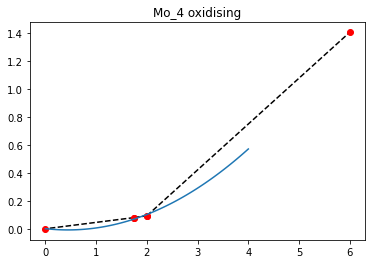

[ 0.04575071 -0.04076598  0.00091027]
W4_ox


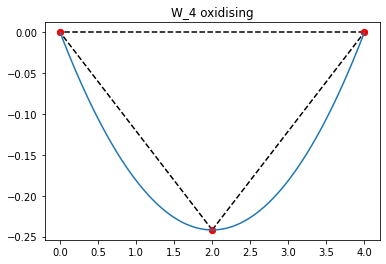

[ 6.04640866e-02 -2.41856346e-01  1.28197512e-16]
Nb4_ox


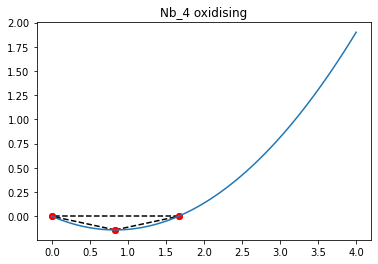

[ 2.03533174e-01 -3.39086268e-01  6.40987562e-17]
Ni4_ox


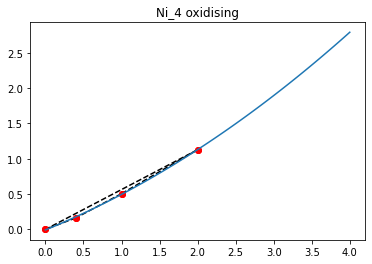

[ 0.0654324   0.43725664 -0.00716656]
V4_ox


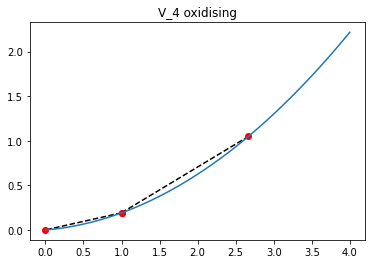

[1.20920235e-01 7.04816444e-02 5.60864117e-17]
Ir4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


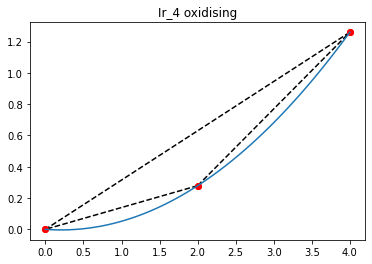

[ 8.77254697e-02 -3.60181875e-02  1.12172823e-16]
Cr4_ox
None
Fe4_ox


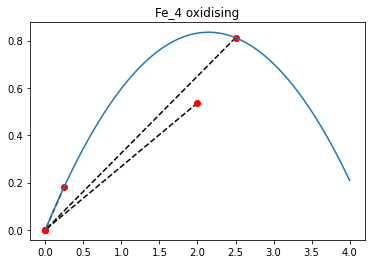

[-1.81759817e-01  7.79326519e-01 -3.20493781e-16]
Mn4_ox


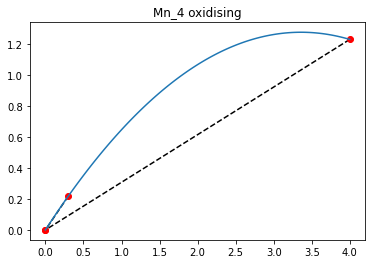

[-1.13345987e-01  7.61590305e-01 -2.56395025e-16]
Co4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
Sb4_ox


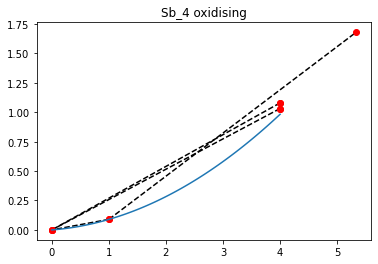

[5.20194626e-02 3.75758234e-02 3.04469092e-16]
Sn4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


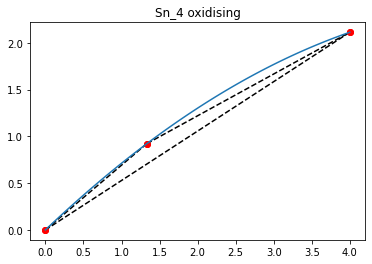

[-6.12778783e-02  7.73069941e-01  1.28197512e-16]
Bi4_ox
None
Ti4_ox


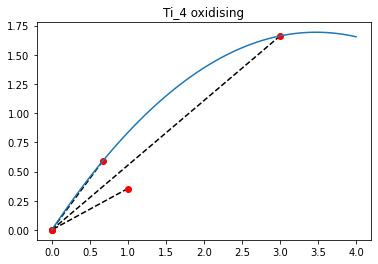

[-0.14039473  0.97523072  0.        ]
Ta4_ox


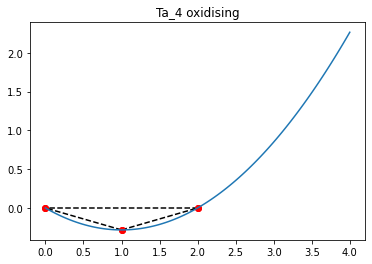

[ 2.83081136e-01 -5.66162273e-01  2.56395025e-16]
In4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
Pt4_ox


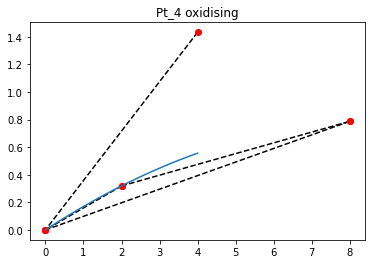

[-1.01594678e-02  1.79661255e-01  1.28197512e-16]
Re4_ox


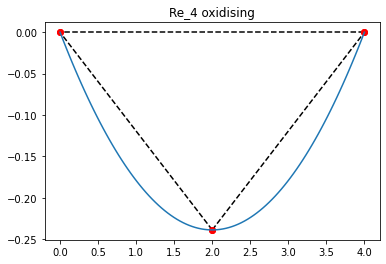

[ 5.97017553e-02 -2.38807021e-01  1.92296269e-16]
Ge4_ox


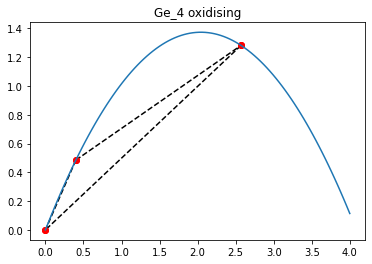

[-3.28826900e-01  1.34381347e+00  6.40987562e-16]
Rh4_ox
Rh  odd.


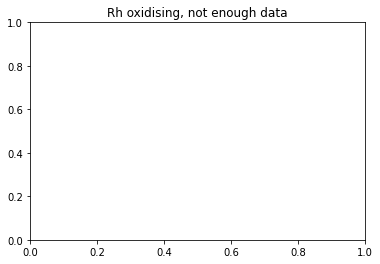

Cu4_ox
Cu  odd.


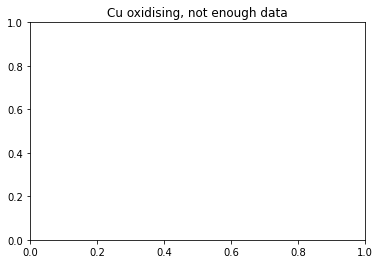

Te4_ox


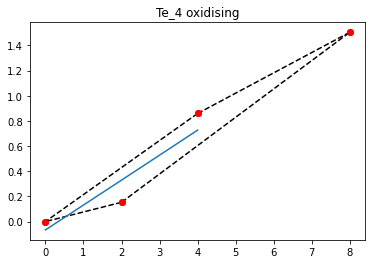

[ 0.00021606  0.19728977 -0.066068  ]
Li4_ox


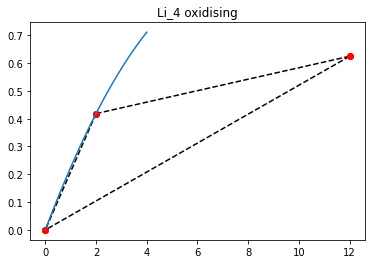

[-1.57072787e-02  2.40525823e-01 -1.28197512e-16]
Na4_ox


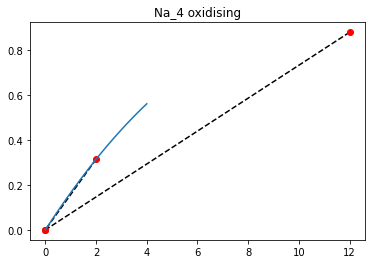

[-8.38004681e-03  1.73916920e-01  1.28197512e-16]
Mg4_ox
Mg  odd.


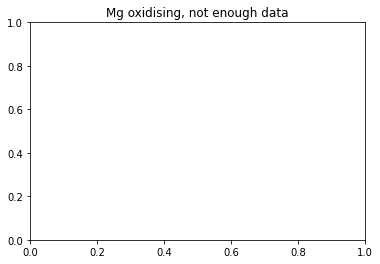

Y4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


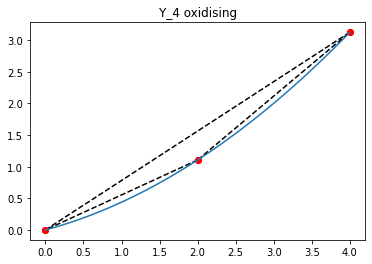

[1.14226103e-01 3.24474395e-01 6.40987562e-17]
Ca4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.
None
Sc4_ox
WARNING! Adding an end member so can perform fit, try gather more data for this element.


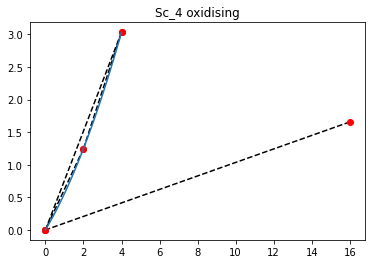

[ 6.72924586e-02  4.89240693e-01 -2.56395025e-16]
Zn4_ox
Zn  odd.


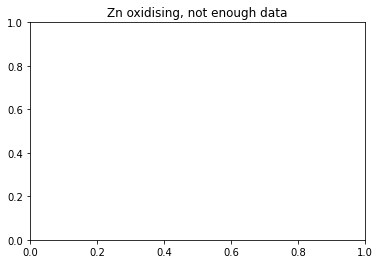

Mo4_red


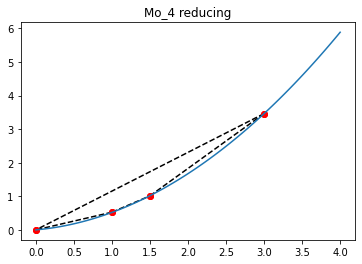

W4_red


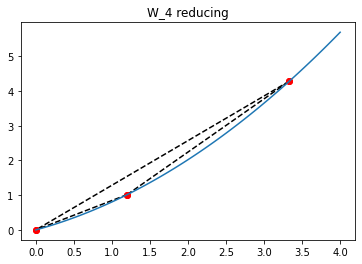

Nb4_red


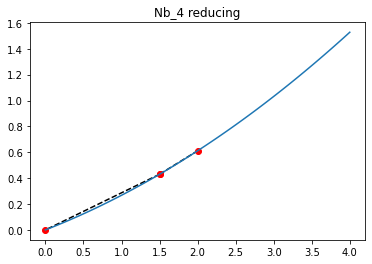

Ni4_red


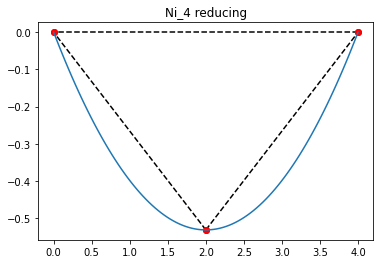

V4_red


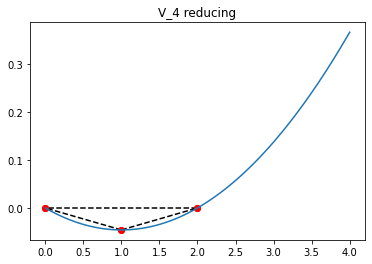

Ir4_red
Ir  odd.


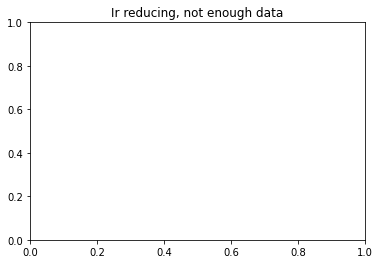

Cr4_red


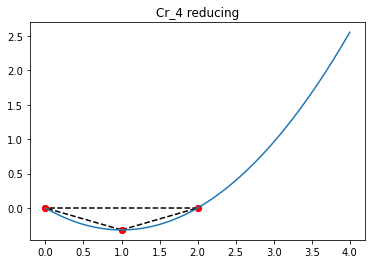

Fe4_red


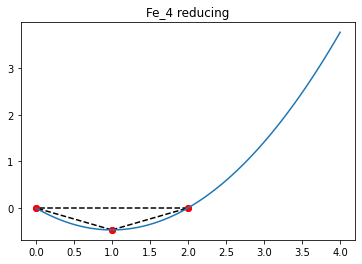

Mn4_red


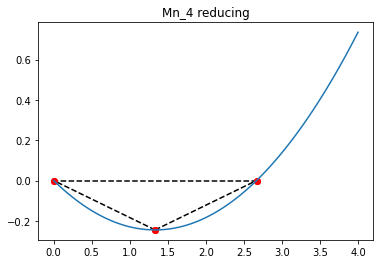

Co4_red


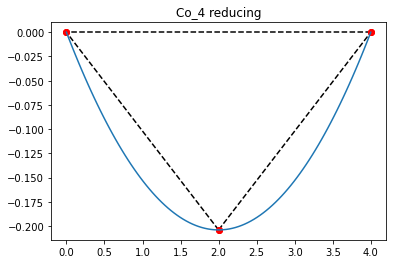

Sb4_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.


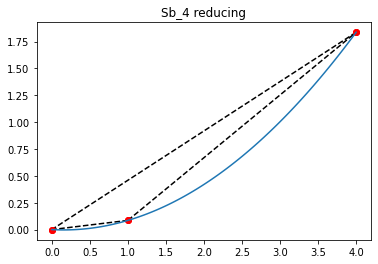

Sn4_red


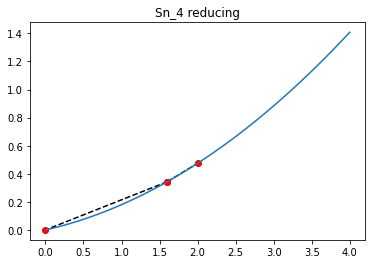

Bi4_red


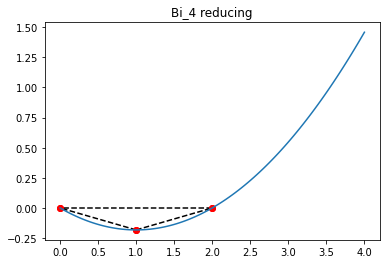

Ti4_red


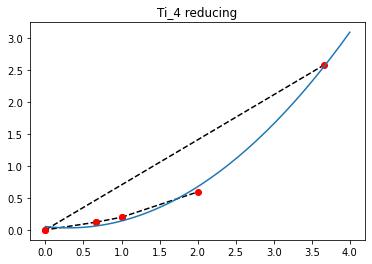

Ta4_red


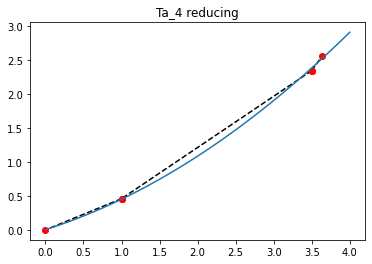

In4_red


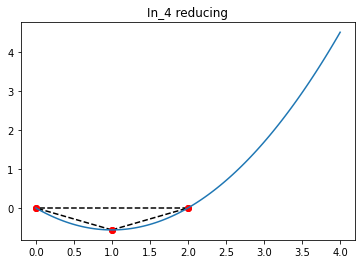

Pt4_red


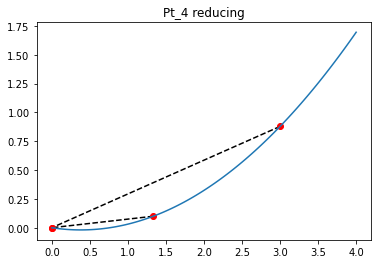

Re4_red
Re  odd.


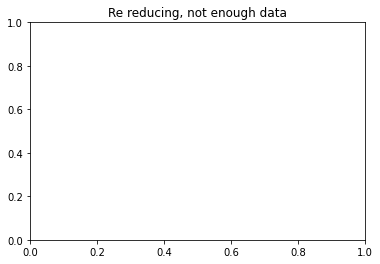

Ge4_red


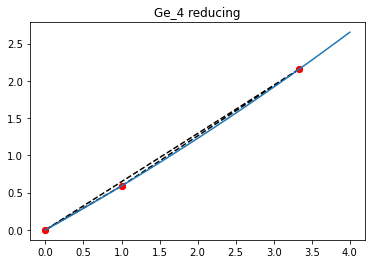

Rh4_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.


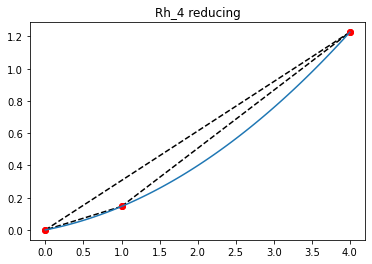

Cu4_red


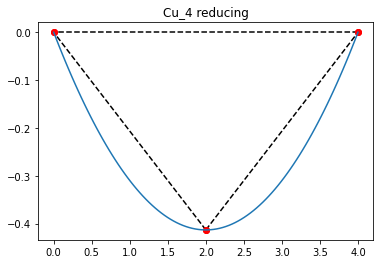

Te4_red
WARNING! Adding an end member so can perform fit, try gather more data for this element.
Li4_red


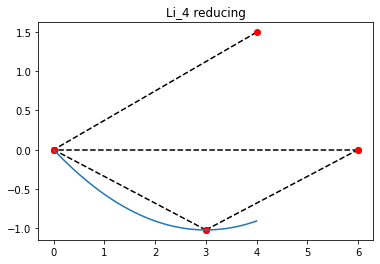

Na4_red


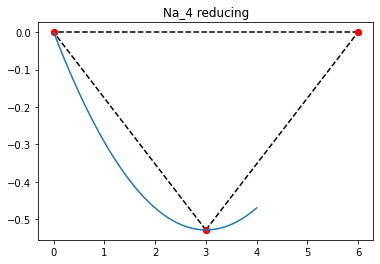

Mg4_red


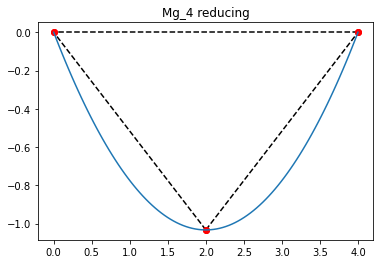

Y4_red


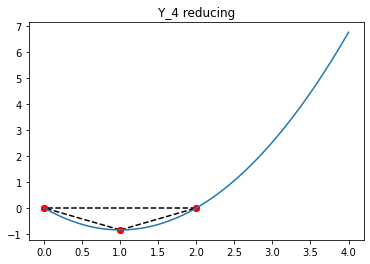

Ca4_red


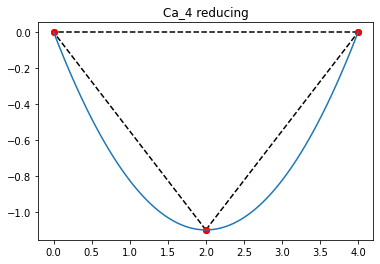

Sc4_red


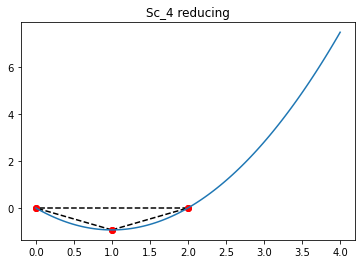

Zn4_red


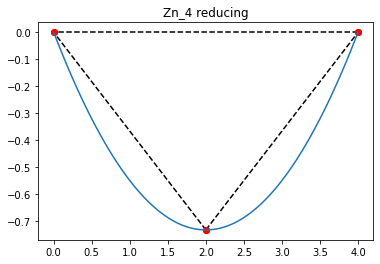

In [6]:
mp_quadratic_equations_ox = defaultdict()
mp_quadratic_equations_red = defaultdict()

eles2consider = [
    "Mo", "W", "Nb", "Ni", "V", "Ir", "Cr", "Fe", "Mn", "Co", "Sb",
    "Sn", "Bi", "Ti", "Ta", "In", "Pt", "Re", "Ge", "Rh", "Cu", 
    "Te", "Li", "Na", "Mg", "Y", "Ca", "Sc", "Zn",
]

for ox_iter in ox_states:
    for ele in eles2consider:
        print("{}{}_ox".format(ele, ox_iter))
        try:
            ox2low, form_ene = get_ox2lowest(ele, ele2mp[ox_iter][ele], ox_iter, oxidising=True)
        except KeyError:
            continue
        hull_ox2energy = get_lower_hull_symmetric(ox2low, ox_iter, form_ene, ele, oxidising=True)
        if hull_ox2energy is None:
            mp_quadratic_equations_ox[ele+str(int(ox_iter))] = [0, -form_ene/(8-ox_iter),0]
            continue

        coeffs = get_quadratic(hull_ox2energy)
        print(coeffs)
        mp_quadratic_equations_ox[ele+str(int(ox_iter))] = coeffs
        if mp_quadratic_equations_ox[ele+str(int(ox_iter))] is None:
            mp_quadratic_equations_ox[ele+str(int(ox_iter))] = [0, -form_ene/(8-ox_iter), 0]

    for ele in eles2consider:
        print("{}{}_red".format(ele, ox_iter))
        ox2low, form_ene = get_ox2lowest(ele, ele2mp[ox_iter][ele], ox_iter, oxidising=False)

        hull_ox2energy = get_lower_hull_symmetric(ox2low, ox_iter, form_ene, ele, oxidising=False)
        if hull_ox2energy is None:
            mp_quadratic_equations_red[ele+str(int(ox_iter))] = [0, -form_ene/ox_iter, 0]
            continue
        try:
            coeffs = get_quadratic(hull_ox2energy)
            mp_quadratic_equations_red[ele+str(int(ox_iter))] = coeffs

        except TypeError:
            mp_quadratic_equations_red[ele+str(int(ox_iter))] = coeffs

        if mp_quadratic_equations_red[ele+str(int(ox_iter))] is None:
            mp_quadratic_equations_red[ele+str(int(ox_iter))] = [0, -form_ene/ox_iter, 0]

    for ele_ox in mp_quadratic_equations_red:
        if mp_quadratic_equations_red[ele_ox][0]<0:
            # cant have this curvature
            mp_quadratic_equations_red[ele_ox][0]=0
        if mp_quadratic_equations_ox[ele_ox][0]<0:
            mp_quadratic_equations_ox[ele_ox][0]=0
    

    

In the above plots, any time a line is fitted through points that means we have got coefficients by ordinary least squares. Many times there is not enough data to fit through, and in those cases we just take the parabola to be some linear function found by dividing the formation energy by an appropriate value depending on the oxidation state. In cases where the curve plotted is concave down, we set the first coefficient to 0.

```
if mp_quadratic_equations_red[ele_ox][0]<0:
    mp_quadratic_equations_red[ele_ox][0] = 0
```

A number of these parabolas we deem should not be shaped as they are to meet the criteria discussed in the paper that they should match the shape of the hull from the reference oxidation state, we list them here. You can check whether the plots yourself by doing a control+F of `Ni4_ox` for instance. This curve appears wrong since it supposes that Ni prefers 5+ to 4+ when this is likely just a facet of the large instability of the NiO2 entry.

Ni4_ox
we set by hand by inspecting Materials Project 

In [7]:
mp_quadratic_equations_ox['Ni4'] = [0, 0.5, 0]



# Printing parabola coefficients as in Table D1

In [11]:
for ox_iter in ox_states:
    print(ox_iter)
    for ele in eles2consider:
        print(ele, end=", ")
        print("{:.2f}".format(mp_quadratic_equations_ox[ele+str(int(ox_iter))][0]), end=", ")
        print("{:.2f}".format(mp_quadratic_equations_ox[ele+str(int(ox_iter))][1]), end=", ")
        print("{:.2f}".format(mp_quadratic_equations_red[ele+str(int(ox_iter))][0]), end=", ")
        print("{:.2f}".format(mp_quadratic_equations_red[ele+str(int(ox_iter))][1]))


4
Mo, 0.05, -0.04, 0.32, 0.20
W, 0.06, -0.24, 0.21, 0.60
Nb, 0.20, -0.34, 0.04, 0.23
Ni, 0.00, 0.50, 0.13, -0.53
V, 0.12, 0.07, 0.05, -0.09
Ir, 0.09, -0.04, 0.00, 0.31
Cr, 0.00, 0.51, 0.32, -0.64
Fe, 0.00, 0.78, 0.47, -0.94
Mn, 0.00, 0.76, 0.14, -0.37
Co, 0.00, 0.27, 0.05, -0.20
Sb, 0.05, 0.04, 0.12, -0.04
Sn, 0.00, 0.77, 0.06, 0.12
Bi, 0.00, 0.36, 0.18, -0.36
Ti, 0.00, 0.98, 0.22, -0.14
Ta, 0.28, -0.57, 0.09, 0.36
In, 0.00, 0.36, 0.56, -1.13
Pt, 0.00, 0.18, 0.13, -0.10
Re, 0.06, -0.24, 0.00, 0.47
Ge, 0.00, 1.34, 0.02, 0.57
Rh, 0.00, 0.31, 0.05, 0.09
Cu, 0.00, 0.13, 0.10, -0.41
Te, 0.00, 0.20, 0.00, 0.37
Li, 0.00, 0.24, 0.11, -0.68
Na, 0.00, 0.17, 0.06, -0.35
Mg, 0.00, 0.51, 0.26, -1.03
Y, 0.11, 0.32, 0.84, -1.69
Ca, 0.00, 0.55, 0.28, -1.10
Sc, 0.07, 0.49, 0.93, -1.87
Zn, 0.00, 0.26, 0.18, -0.73
